<a href="https://colab.research.google.com/github/akaliutau/tensorflow-grimoire/blob/main/notebooks/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning the timeseries data

In [127]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## A temperature-forecasting example

In [22]:
!wget -O climate_data.zip https://github.com/akaliutau/tensorflow-grimoire/blob/main/data/climate_data.zip?raw=true
!unzip -o climate_data.zip

--2025-01-05 12:08:21--  https://github.com/akaliutau/tensorflow-grimoire/blob/main/data/climate_data.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/akaliutau/tensorflow-grimoire/raw/refs/heads/main/data/climate_data.zip [following]
--2025-01-05 12:08:21--  https://github.com/akaliutau/tensorflow-grimoire/raw/refs/heads/main/data/climate_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/akaliutau/tensorflow-grimoire/refs/heads/main/data/climate_data.zip [following]
--2025-01-05 12:08:21--  https://raw.githubusercontent.com/akaliutau/tensorflow-grimoire/refs/heads/main/data/climate_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to ra

**Inspecting the data of the Jena weather dataset**

In [23]:
import os
fname = os.path.join("climate_2016.csv")

df = pd.read_csv(fname)
df = df.drop(columns=["Date Time"])
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,988.67,6.88,280.96,5.94,93.7,9.95,9.32,0.63,5.88,9.43,1225.48,5.03,6.93,31.22
1,988.68,6.51,280.58,5.60,93.9,9.70,9.10,0.59,5.75,9.21,1227.22,4.11,5.81,25.78
2,988.82,6.35,280.41,5.50,94.3,9.59,9.04,0.55,5.71,9.14,1228.15,3.60,5.57,26.16
3,988.87,6.25,280.31,5.48,94.8,9.52,9.03,0.50,5.70,9.13,1228.62,3.00,4.08,28.61
4,988.86,6.18,280.23,5.39,94.7,9.47,8.97,0.50,5.66,9.07,1228.98,2.95,4.12,25.28


**Parsing the data**

In [83]:
lines = df.shape[0]
cols = df.shape[1]
temperature = np.zeros((lines,))
raw_data = np.zeros((lines, cols))
numpy_array = df.values
numpy_array = numpy_array.astype(float)
for i, line in enumerate(numpy_array):
    temperature[i] = line[1]
    raw_data[i, :] = line[:]

**Plotting the temperature timeseries**

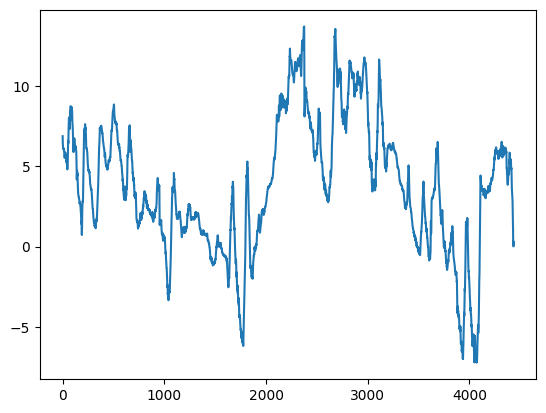

In [126]:
plt.plot(range(lines), temperature)

**Plotting the first 10 days of the temperature timeseries**

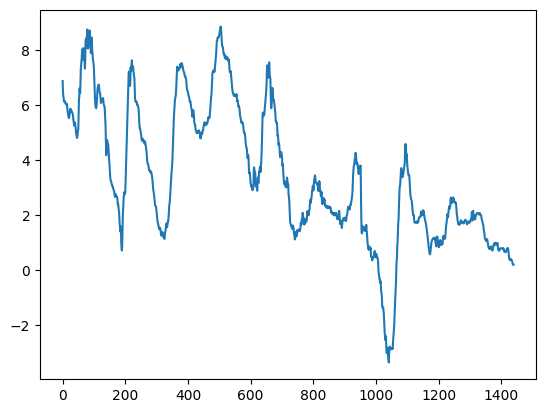

In [85]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [86]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 2217
num_val_samples: 1108
num_test_samples: 1110


### Preparing the data

**Normalizing the data**
Note, only feature data is normalized - the target vector was left untouched

In [87]:
mean = raw_data[:num_train_samples].mean(axis=0) # mean by columns (axis=0) across all rows
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0) # std by columns (axis=0) across all rows
raw_data /= std

**Instantiating datasets for training, validation, and testing**

We are trying to predict the tempr after 24h of observations, with shift by 1 point on each next prediction

In [130]:
sampling_rate = 1     # How much to skip in the input sequence (1 means no skipping)
sequence_length = 24   # Length of each input window
sequence_stride = 1  # How much to shift each window
#delay = sampling_rate * (sequence_length - 1)  # point with offset 144 is the prediction
batch_size = 64      # Number of sequences per batch

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets=temperature,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets=temperature,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples, # validation data should be from future!
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets=temperature,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [100]:
print(raw_data)
print(temperature)


[[ 0.04503292  1.28538596  1.12213833 ...  2.89457726  2.42154693
  -2.09081478]
 [ 0.04603751  1.16866657  1.01682149 ...  2.05098405  1.72993581
  -2.16939078]
 [ 0.06010175  1.11819332  0.96970606 ...  1.58333998  1.58173343
  -2.16390202]
 ...
 [ 0.74523094 -0.80294469 -0.87333875 ... -0.32391425 -0.56102601
   0.91471725]
 [ 0.74523094 -0.78401722 -0.85670978 ... -0.20471086 -0.6474774
   0.92482813]
 [ 0.74924929 -0.87865456 -0.94262615 ... -0.20471086 -0.37577303
   0.83960784]]
[6.88 6.51 6.35 ... 0.26 0.32 0.02]


In [110]:
# Get the first element
first_batch = list(train_dataset.take(1))[0]

# The first batch is a tuple with shape (inputs, targets) if you provided the target
inputs, targets = first_batch
print("First Input Sequence:", inputs[0])
print("First Target Sequence:", targets[0])


First Input Sequence: tf.Tensor(
[[ 1.04057989 -0.74931686 -0.88996773 -0.9737164  -0.54735875 -0.77878484
  -0.97304981  0.13562699 -1.00023223 -0.9982827   1.03676084 -0.25972781
  -0.44987423 -1.87039754]
 [ 1.04158447 -0.74300771 -0.88442474 -1.06431522 -0.72653314 -0.7729954
  -1.04640597  0.25587477 -1.06220745 -1.06931233  1.03591346 -0.67235493
  -0.83273038 -1.66557995]
 [ 1.04258906 -0.72723482 -0.87056726 -1.089308   -0.8061662  -0.76141653
  -1.0664122   0.32146447 -1.08286586 -1.08868404  1.02659225 -0.96577866
  -0.80802998 -1.15512483]
 [ 1.04057989 -0.68937988 -0.83730931 -1.15803813 -0.99529472 -0.72667992
  -1.11976214  0.46357548 -1.13451188 -1.13388471  1.00371292 -0.58066001
  -0.42517383  0.03940371]
 [ 1.0395753  -0.67045241 -0.82068033 -1.27675382 -1.24414803 -0.70931161
  -1.21312453  0.64941295 -1.22747472 -1.22428606  0.99396802 -0.32391425
  -0.15346946  0.03218165]
 [ 1.04158447 -0.66414326 -0.81513734 -1.45795146 -1.56268027 -0.70931161
  -1.34649937  0.87

**Inspecting the output of one of our datasets**

In [66]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (64, 24, 14)
targets shape: (64,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [90]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.42
Test MAE: 1.53


### Non-timeseries simple machine-learning model (alt ML-based baseline)

In [91]:
print(len(list(train_dataset)))
print(len(list(val_dataset)))
print(len(list(test_dataset)))

35
17
17


**Training and evaluating a densely connected model**
In this case we are using temperature

In [108]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1] )) # input is a block of lines of 14 float values, organized as a block of 24
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
y = layers.Dense(1)(x)
model = keras.Model(inputs, y)

callbacks = [
    keras.callbacks.ModelCheckpoint("climate_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 24, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 336)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 16)                  │           5,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
inputs, targets = first_batch

history = model.fit(inputs, targets, epochs=5, batch_size=64, callbacks=callbacks)
inputs, targets = list(test_dataset.take(1))[0]

print(f"Test MAE: {model.evaluate(inputs, targets)[1]:.2f}")

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8383 - mae: 0.7317
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.7658 - mae: 0.6884
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7293 - mae: 0.6565
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6965 - mae: 0.6501
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6657 - mae: 0.6244
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6662 - mae: 1.4299 
Test MAE: 1.42


**A simple LSTM-based model**

In [133]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("climate_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("climate_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 24, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 14.7890 - mae: 2.9924 - val_loss: 48.7913 - val_mae: 6.3489
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.3974 - mae: 2.0141 - val_loss: 27.4637 - val_mae: 4.5136
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.8708 - mae: 1.4352 - val_loss: 17.8952 - val_mae: 3.6012
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 2.2222 - mae: 1.0366 - val_loss: 14.7189 - val_mae: 3.2255
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.8228 - mae: 0.9094 - val_loss: 14.9805 - val_mae: 3.2564
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5176 - mae: 0.8156 - val_loss: 14.5767 - val_mae: 3.2052
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2337 - mae: 0.7133 - val_loss: 18.8178 - val_mae: 3.5085
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8192 - mae: 0.5965 - val_loss: 19.6844 - val_mae: 3.5625
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

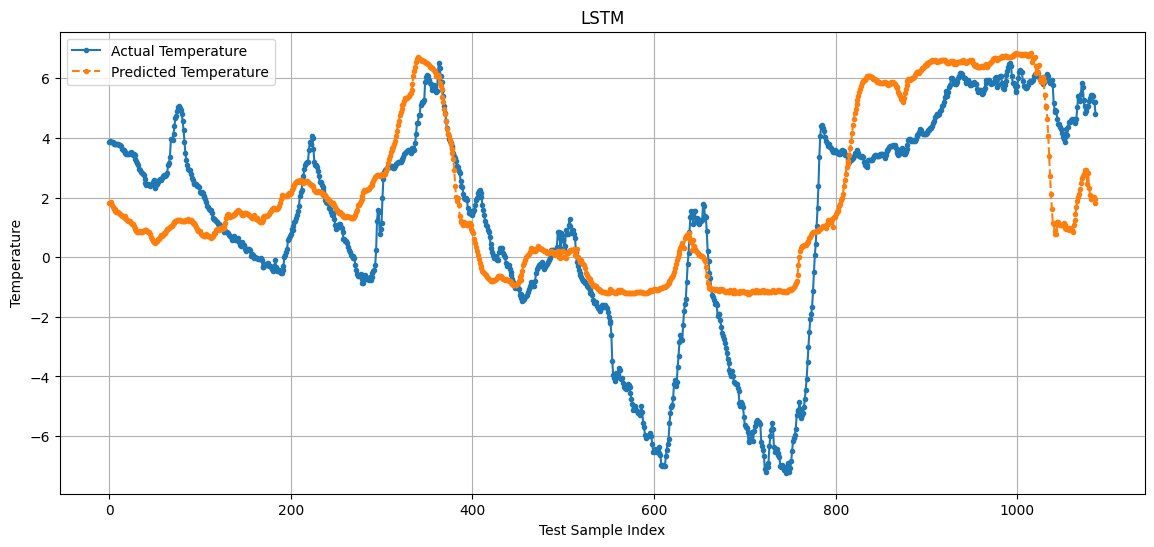

In [134]:
actual_temps = []
predicted_temps = []
title = "LSTM"
for input, y_batch in test_dataset.take(int(len(list(test_dataset)))):
    y_hat = model.predict(input, verbose=0)  # Get the predictions
    actual_temps.extend(y_batch.numpy().flatten())
    predicted_temps.extend(y_hat.flatten())

plt.figure(figsize=(14, 6)) # Adjust figure size if necessary
plt.plot(actual_temps, label="Actual Temperature", marker='.', linestyle='-')
plt.plot(predicted_temps, label="Predicted Temperature", marker='.', linestyle='--')

plt.xlabel("Test Sample Index")
plt.ylabel("Temperature")
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()

## Recurrent neural networks

**Toy model of the simple RNN**

In [135]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [136]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [137]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [138]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [139]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [140]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("climate_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 10.0747 - mae: 2.5058 - val_loss: 18.0347 - val_mae: 3.6475
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.7144 - mae: 1.5086 - val_loss: 11.7677 - val_mae: 2.9588
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8128 - mae: 1.2774 - val_loss: 10.8287 - val_mae: 2.8251
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.5745 - mae: 1.2002 - val_loss: 11.2369 - val_mae: 2.8631
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.1694 - mae: 1.1169 - val_loss: 10.1651 - val_mae: 2.6934
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9849 - mae: 1.0537 - val_loss: 8.4645 - val_mae: 2.4649
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7568 - mae: 1.0132 - val_loss: 10.1229 - val_mae: 2.7152
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.7667 - mae: 1.0107 - val_loss: 9.8041 - val_mae: 2.6648
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss

In [141]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)